In [1]:
from pyspark import SparkConf, SparkContext

# In Jupyter you have to stop the current context first
sc.stop()

# Create new config
conf = (SparkConf()
    .set("spark.driver.maxResultSize", "10g"))

# Create new context
sc = SparkContext(conf=conf)

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
%matplotlib inline
mpl.rcParams['figure.figsize']=(10,8)


In [4]:
tokenRDD = sc.textFile('/home/alex/Projects/TRA/tokens.txt', 3 * sc.defaultParallelism)

sc.addPyFile('/home/alex/Projects/TRA/loadocpnpz.py')

In [14]:
import sys
sys.path.append('/home/alex/Projects/TRA')
from loadocpnpz import loadOCPnpz

data_cubes = tokenRDD.filter(lambda line: 'S05' in line ).map( lambda line: ( line, loadOCPnpz(line) ) ).filter( lambda cube_tuple: type(cube_tuple[1]) != int ).cache()


In [22]:



def SquashCubeY(cube_tuple,numbins=10,numbins2=3):
    def entropy(signal):
        '''
        function returns entropy of a signal
        signal must be a 1-D numpy array
        '''
        lensig=signal.size
        symset=list(set(signal))
        numsym=len(symset)
        propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return ent
    
    data = cube_tuple[1][0,:,:]
    #return data.shape

    import skimage as si
    from skimage.measure import regionprops,label
    N,M = data.shape
    

    bins = np.int32(np.linspace(0,M,numbins+1))
    bins2 = np.int32(np.linspace(0,N,numbins2+1))
    #print bins2.shape
    vals = np.zeros(numbins)
    
    bot = np.percentile(data,1)
    top = np.percentile(data,99)
    
    for i in range(numbins):
        temp_vals = np.zeros(numbins2)
        for j in range(numbins2):
            
            data_cut=data[bins2[j]:bins2[j+1],bins[i]:bins[i+1]]
            data_cut=np.ravel(data_cut[data_cut>bot])
            e = entropy(data_cut)
       
            temp_vals[j] = entropy(data_cut)
        vals[i]=np.median(temp_vals)
        
        #data_cut=data_cut[data_cut>bot]
        #data_cut=np.ravel(data_cut[data_cut<top])
        
        #e=entropy(data_cut)
        
        #vals[i]=e
        
    x= (bins[0:-1]+bins[1:])/2
    #plt.plot(x, vals)
    return (cube_tuple[0], x, vals)

results = data_cubes.map(SquashCubeY).collect()

In [20]:
results

[(1106, 4120),
 (1106, 4120),
 (1106, 4120),
 (1106, 4120),
 (1106, 4120),
 (1106, 4120),
 (1106, 4120),
 (1106, 4120),
 (1106, 4120),
 (1106, 4120),
 (1106, 4120)]

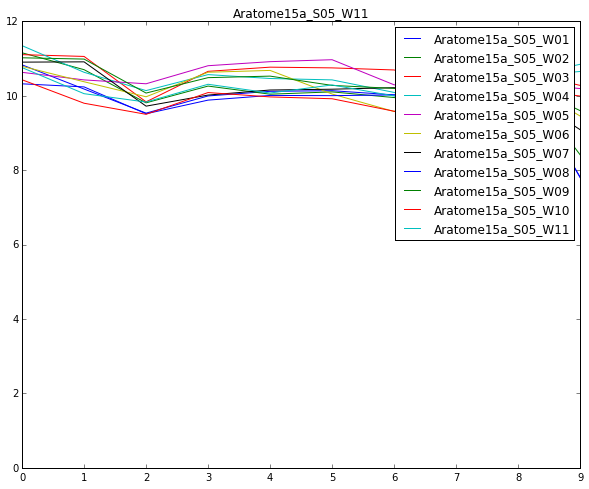

In [23]:
f,ax = plt.subplots()
for result in results:
    #print result[1].shape,result[2].shape
    ax.plot( result[2])
    ax.set_title(result[0])
    ax.set_ylim([0,12])
plt.legend([res[0] for res in results])